In [1]:
# Graphing/Image
SAVE_GRAPHS = True
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
# plt.style.use(['seaborn-whitegrid'])

# Informatics Collaboration Network

In this notebook, we create and visualise three different models of the informatics network:
- [InfNet-20yr](#Simple-collaboration-network) : everyone in the School
- [InfNet-6yr](#6yr-model): network based on the publications from 2012-2017
- [Weighted-InfNet-6yr](#Weighted-6yr-Model) : network weighted by the number of collaboration between nodes

In [2]:
import networkx as nx
import pandas as pd
import pickle as pkl
import numpy as np
from numpy.random import RandomState  # random_state for networkX only for python3.6
rng = RandomState(787351)
import os
DATA_DIR = '../../data/data_schoolofinf'

To create the informatics collaboration network, we need to do additional processing to the lookup tables (dataframe) for `poinf` and `pub`.

## Setup `lookup_pub`

Filter the list of publications, limiting the dataset to a period from 1997-2017. Further constraints will be carried out later for each model.

In [3]:
# Import the dataset for publication:
lookup_pub_original = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_pub.pkl'))
print('Original Dataset have ', len(lookup_pub_original), " publications")

# Constraint the dataset to publications within 1997-2017:
lookup_pub = lookup_pub_original.drop(
    lookup_pub_original[(lookup_pub_original.year < 1997)
                        | (lookup_pub_original.year > 2017)].index)
print(('Within 1997-2017, there are {} publications'.format(len(lookup_pub))))

Original Dataset have  8867  publications
Within 1997-2017, there are 8028 publications


In [4]:
lookup_pub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8028 entries, 18b1a861-afef-4fff-bc80-d02e05be18c4 to b2920a27-5293-4f4a-8874-4a0ea804d91a
Data columns (total 5 columns):
year          8028 non-null int64
authors       8028 non-null object
shortnames    8027 non-null object
collab_id     8028 non-null object
edges         8028 non-null object
dtypes: int64(1), object(4)
memory usage: 376.3+ KB


We can add the year that an individual makes his/her first publication. This would allow us to create a temporal evolution of the network graph.

## Setup `lookup_poinf` 

In [6]:
lookup_poinf = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_poinf.pkl'))

In [7]:
lookup_poinf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 23d17ab4-123f-4929-9373-763bd7587df8 to ccd9cd8c-9aee-4ede-a388-f82641ee8d29
Data columns (total 9 columns):
last_name          288 non-null object
first_name         288 non-null object
personal_url       288 non-null object
position           288 non-null object
parent             288 non-null object
institute          288 non-null object
full_name          288 non-null object
institute_class    288 non-null int64
alias              228 non-null object
dtypes: int64(1), object(8)
memory usage: 22.5+ KB


In [8]:
# !! FOR THE PURPOSE OF THE ADJACENCY MATRIX AND COLLABORATION GRAPH,
# WE WILL USE A STRICTER CONDITION TO FILTER LOOKUP_PUB
# Append earliest date to lookup_poinf
lookup_pub_sorted_yrs = lookup_pub_original.sort_values('year')
# lookup_pub_sorted_yrs.drop(['authors', 'shortnames'], inplace=True, axis=1)
lookup_pub_sorted_yrs[
    'poinf_collaborators'] = lookup_pub_sorted_yrs['collab_id'].apply(
        lambda collab_id: [a for a in collab_id if a in lookup_poinf.index])
print((len(lookup_pub_sorted_yrs)))

# remove collaborations that have only one collaborator from informatics.
lookup_pub_sorted_yrs['num_poinf_collabs'] = lookup_pub_sorted_yrs[
    'poinf_collaborators'].apply(len)
lookup_pub_sorted_yrs = lookup_pub_sorted_yrs[
    lookup_pub_sorted_yrs.num_poinf_collabs.ge(2)]
print((len(lookup_pub_sorted_yrs)))

8867
1193


In [9]:
def get_firstPublishDate(poinf_id):
    for collab in lookup_pub_sorted_yrs.iterrows():
        poinf_collabs = collab[1]['poinf_collaborators']
        if poinf_id in poinf_collabs:
            return int(collab[1]['year'])
    return None

# Using the data available, append the earliest date where the individual is seen in the network
# In other words, the first publication with another individual from the network.
lookup_poinf['first_pub_year'] = lookup_poinf.index.map(get_firstPublishDate)
lookup_poinf.drop(
    lookup_poinf[lookup_poinf.first_pub_year.isnull()].index, inplace=True)

<b>
!! The number of alias is greater than the number of first_pub_year because first_pub_year is based on the first `collaborated` work in the school (i.e. two or more individuals from the School in a publication)
</b>

In [9]:
lookup_poinf.to_pickle(os.path.join(DATA_DIR, 'lookup_poinf_w_yr.pkl'))

In [5]:
lookup_poinf = pd.read_pickle(os.path.join(DATA_DIR, 'lookup_poinf_w_yr.pkl'))

In [6]:
lookup_poinf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, d089bb44-7d0b-4b3f-b556-27def993d1d1 to ccd9cd8c-9aee-4ede-a388-f82641ee8d29
Data columns (total 10 columns):
last_name          194 non-null object
first_name         194 non-null object
personal_url       194 non-null object
position           194 non-null object
parent             194 non-null object
institute          194 non-null object
full_name          194 non-null object
institute_class    194 non-null int64
alias              194 non-null object
first_pub_year     194 non-null float64
dtypes: float64(1), int64(1), object(8)
memory usage: 16.7+ KB


## Exploring both lookup tables

In [7]:
lookup_pub['num_authors'] = lookup_pub.authors.apply(
    lambda x: len(x.split('|')))
lookup_pub['num_poinf'] = lookup_pub.collab_id.apply(
    lambda collab_id: len([a for a in collab_id if a in lookup_poinf.index]))
lookup_pub.head(3)

year  \
pub_id                                       
18b1a861-afef-4fff-bc80-d02e05be18c4  2013   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  2012   
880944d3-26db-4003-9186-130bf3202941  2014   

                                                                                authors  \
pub_id                                                                                    
18b1a861-afef-4fff-bc80-d02e05be18c4                   paolo guagliardo|piotr wieczorek   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  p.l. de leon|m. pucher|j. yamagishi|i. hernaez...   
880944d3-26db-4003-9186-130bf3202941  navid nikaein|mahesh k. marina|saravana manick...   

                                                                             shortnames  \
pub_id                                                                                    
18b1a861-afef-4fff-bc80-d02e05be18c4                       guagliardo, p.|wieczorek, p.   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  leon, p. l.|pucher, m.|yamagishi, j.|hernaez, ...   
880944d3-26db-4003-9186-130bf3202941  nikaein, n.|marina, m. k.|manickam, s.|dawson,...   

                                                                              collab_id  \
pub_id                                                                                    
18b1a861-afef-4fff-bc80-d02e05be18c4       [653c9723-b374-4ad3-9cef-0f7e7f45d812, 1852]   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [857, 6478, 4d11a99a-0d04-42f4-8089-d433a57c24...   
880944d3-26db-4003-9186-130bf3202941  [6362, 06760916-edca-488e-93da-baff6204a453, 3...   

                                                                                  edges  \
pub_id                                                                                    
18b1a861-afef-4fff-bc80-d02e05be18c4     [(653c9723-b374-4ad3-9cef-0f7e7f45d812, 1852)]   
d5814bab-5fc2-4c31-92b7-543c7ce75cb4  [(857, 6478), (857, 4d11a99a-0d04-42f4-8089-d4...   
880944d3-26db-4003-9186-130bf3202941  [(6362, 06760916-edca-488e-93da-baff6204a453),...   

                                      num_authors  num_poinf  
pub_id                                                        
18b1a861-afef-4fff-bc80-d02e05be18c4            2          1  
d5814bab-5fc2-4c31-92b7-543c7ce75cb4            5          1  
880944d3-26db-4003-9186-130bf3202941            6          1

In [132]:
len(lookup_pub[lookup_pub.num_poinf == 0])

738

In [134]:
738/len(lookup_pub)

0.09192825112107623

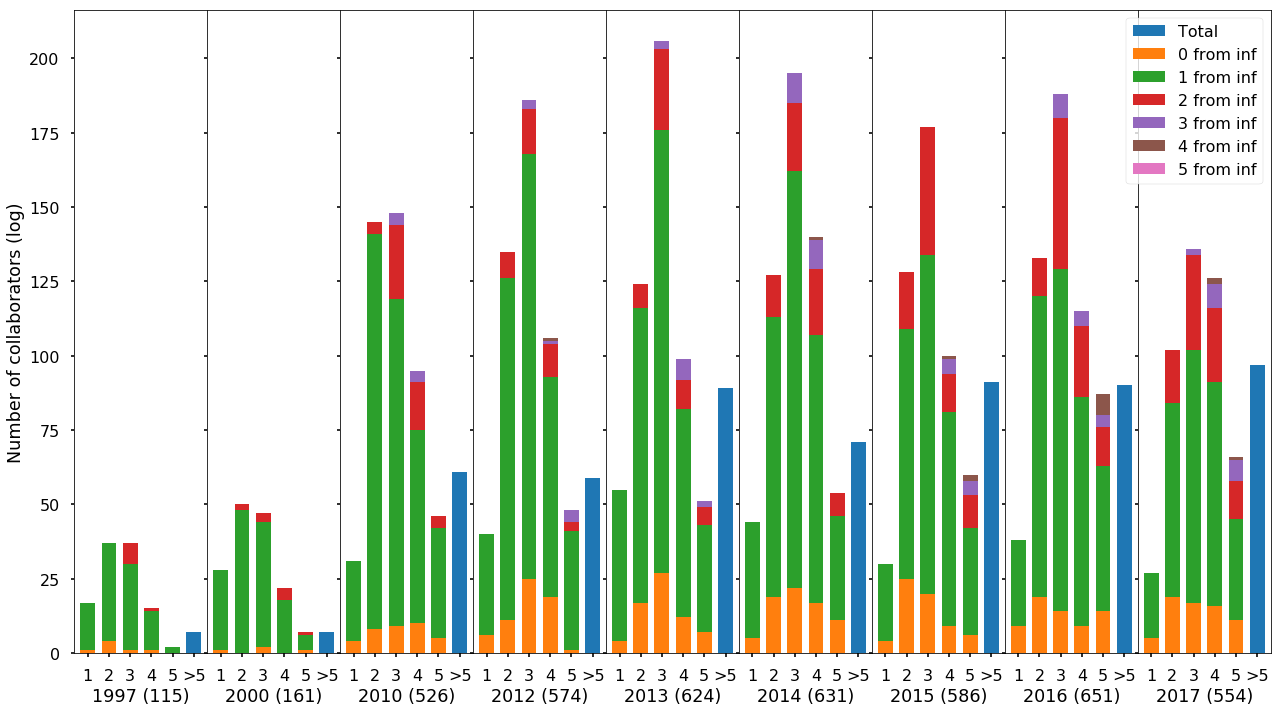

In [130]:
plt.style.use(['seaborn-poster'])
selected_years = [1997, 2000, 2010, 2012, 2013, 2014, 2015, 2016, 2017]
fig = plt.figure(figsize=(40, 10))
count = 0
ind = [1, 2, 3, 4, 5]
xs = [1, 2, 3, 4, 5, '>5']
width = .7
_ax_ref = None
for yr in selected_years:
    df = lookup_pub[lookup_pub.year.eq(yr)]
    count += 1
    if count == 1:
        ax = fig.add_subplot(1, 21, count)
        #         ax.set_yscale("log")
        ax.set_ylabel('Number of collaborators (log)')
        _ax_ref = ax

    else:
        ax = fig.add_subplot(1, 21, count, sharey=ax)
        for tk in ax.get_yticklabels():
            tk.set_visible(False)

    total_pub = len(df)
    num_authors = []
    num_poinfs = []
    for i in ind:
        _df = df[df.num_authors.eq(i)]
        num_authors.append(len(_df))

    num_authors.append(total_pub - np.sum(num_authors))  # more than 5
    bar_auth = ax.bar(
        xs,
        num_authors,
        width=width,
        label="Total",
        align="center",
        log=False,
    )

    bars_mat = np.zeros([len(ind), len(ind) + 1])
    offset_mat = np.zeros([len(ind), len(ind) + 1])
    for num_collab_i in ind:  # upper limit
        _df = df[df.num_authors.eq(num_collab_i)]

        for possible_inf_i in range(num_collab_i + 1):
            bars_mat[num_collab_i - 1][possible_inf_i] = len(
                _df[_df.num_poinf.eq(possible_inf_i)])
        offset_mat[num_collab_i - 1] = bars_mat[num_collab_i - 1]
    bars_mat = np.transpose(bars_mat)
    #     print(bars_mat)
    for row in range(len(xs)):
        if row == 0:
            btm = np.zeros_like(bars_mat[row])
        else:
            btm = np.sum(bars_mat[:row], axis=0)
        ax.bar(
            ind,
            bars_mat[row],
            bottom=btm,
            align='center',
            width=width,
            log=False,
            label='{} from inf'.format(row))
    ax.set_xticks(xs)
    ax.set_xlabel('{} ({})'.format(yr, len(df)))

plt.legend()
plt.tight_layout()
plt.subplots_adjust(wspace=0)

if SAVE_GRAPHS:
    plt.savefig(
        'IMG/distr_by_yr_1-5.png',
        format='png',
        transparent=True,
        bbox_inches='tight')

## Import `institutes` information

Class labels for each institute

In [8]:
institutes = pkl.load(open(os.path.join(DATA_DIR, 'institutes.pkl'), 'rb'))

In [9]:
# separate the individuals by community:
infcommunity = {}
gb = lookup_poinf.groupby('institute_class')
# Number of individuals in each classes:
for k, group in gb:
    infcommunity[k] = group
    className = [name for (name, _k) in list(institutes.items()) if _k == k][0]
    print(('class {}-{}: {}'.format(k, className, len(group))))

class 0-UNKNOWN: 8
class 1-centre for intelligent systems and their applications: 16
class 2-institute of language cognition and computation: 46
class 3-laboratory for foundations of computer science: 53
class 4-institute for adaptive and neural computation: 22
class 5-institute for computing systems architecture: 21
class 6-neuroinformatics dtc: 11
class 7-institute of perception action and behaviour: 13
class 8-deanery of clinical sciences: 1
class 9-deanery of molecular genetic and population health sciences: 1
class 10-edinburgh neuroscience: 1
class 11-school of philosophy psychology and language sciences: 1


The class distribution is uneven! <b>Classes 1, 2, 3, 4, 5, 6, and 7</b> are the institutes in the school of informatics. Additional classes are found, but they are relatively small, except for the <b>UNKNOWN</b> class which contains individuals who's institutes are not present.

In [10]:
# Create a color map for each institute:
from helper import inst_by_color

In [11]:
print(('Number of individuals in informatics:', len(lookup_poinf)))

('Number of individuals in informatics:', 194)


# Simple collaboration network

This section, we only consider a <b>simple undirected graph</b> of the informatics collaboration network

In [16]:
all_edges = []
for listEdges in lookup_pub.edges:
    all_edges.extend(listEdges)

In [17]:
# Since the graph of interest is simple ud, we remove all repeated edges
unique_edges = set()
for (i1, i2) in all_edges:
    assert i1 != i2, "SELF LOOPS DETECTED!"

    # We are only interested in an simple undirected graph!
    # if the same edge exists, we can ignore
    if (i2, i1) in unique_edges:
        continue
    else:
        # adding another (i1,i2) into the set will only count as one
        unique_edges.add((i1, i2))
        
print('number of unique edge pairs: ', len(unique_edges))

# Filter all edges pairs if there is only one or none individuals from school of informatics
poinf_edges_only = [(au1, au2) for (au1, au2) in unique_edges
                    if au1 in lookup_poinf.index and au2 in lookup_poinf.index]

print('number of unique edge pairs (informatics only): ', len(poinf_edges_only))

number of unique edge pairs:  34811
number of unique edge pairs (informatics only):  470


In [18]:
# light up the nodes based on the institutes they belong to:
def color_by_inst(g):
    node_color = []
    for node in g:
        node_color.append(inst_by_color[int(
            lookup_poinf.institute_class.loc[[str(node)]])])
    return node_color


def add_inst_labels(ax, with_legend=True):
    for label in list(institutes.values()):
        ax.scatter(
            [0], [0],
            color=inst_by_color[label],
            label=[
                name for (name, _k) in list(institutes.items()) if _k == label
            ][0])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.scatter([0], [0], color='white', s=100, edgecolors='none')
    return ax

# `infnet-20yr`

`g_poinf_only`:  the informatics collaboration graph

In [19]:
g_poinf_only = nx.from_edgelist(poinf_edges_only)
# this is the pos for the entire network! we can use this to maintain the visualiation across different experiements
pos = nx.spring_layout(g_poinf_only, random_state=rng, k=.1, scale=10)

In [20]:
print(nx.info(g_poinf_only))

Name: 
Type: Graph
Number of nodes: 194
Number of edges: 470
Average degree:   4.8454


## Generating the adjacency matrix using graph:

In [21]:
NODES_ORDER_20yr = lookup_poinf.index.tolist()
# NODES_ORDER_20yr = list(g_poinf_only.nodes)
# rng.shuffle(NODES_ORDER_20yr)

In [22]:
# create empty matrix that preserves the order that nodes are being added
# This is useful when comparing the output....
adj_mat = np.zeros([len(NODES_ORDER_20yr),len(NODES_ORDER_20yr)])
for i, node in enumerate(NODES_ORDER_20yr):
    neighbours = [n for n in g_poinf_only[node]] 
    for neighbour in neighbours:
        idx = NODES_ORDER_20yr.index(neighbour)
        adj_mat[i][idx] = 1

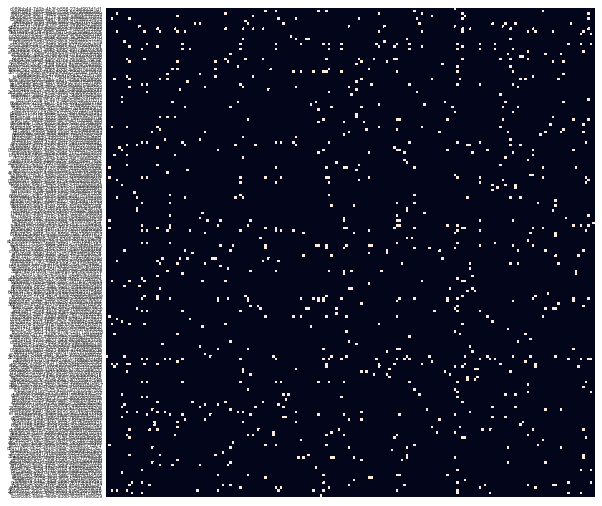

In [23]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111)
sns.heatmap(
    adj_mat,
    square=True,
    yticklabels=NODES_ORDER_20yr,
    xticklabels="",
    ax=ax,
    cbar=False)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(5)
    # specify integer or one of preset strings, e.g.
    #tick.label.set_fontsize('x-small')
    # tick.label.set_rotation('vertical')
if SAVE_GRAPHS:
    plt.savefig(
        'IMG/infnet20yr_adj_mat.png',
        format='png',
        transparent=True,
        bbox_inches='tight')

In [24]:
adj_mat.dump(os.path.join(DATA_DIR,'mat','infnet20yrs-adj-mat.pkl'))

In [25]:
# Save the list of individuals in the graph:
with open(os.path.join(DATA_DIR, 'poinf_collabgraph_1997-017.txt'), 'w') as f:
          f.write("\n".join(list(NODES_ORDER_20yr)))

NOTE: The number of individuals with a publication is expected to by `228`; however, in our graph, only `194` nodes are present. Why? Because we filtered the graph according to the edges where both are individuals are present.

## Drawing Network
Here, we illustrate each network using different layouts

### `Circular Layout` for each class

In [26]:
# Group individuals according to their institute
nlist = {}
for k, gb in lookup_poinf.groupby('institute_class'):
    nlist[k] = gb.index.tolist()

In [27]:
# Put Non-official classes as one list - 'others':
in_school = [i for i in range(1, 8)]
nlist_merged = {'others': []}
for i in list(nlist.keys()):
    if i in in_school:
        nlist_merged[i] = nlist[i]
    else:
        nlist_merged['others'].extend(nlist[i])

In [28]:
# Cross institute collaboration 
edges = []
for (a,b) in g_poinf_only.edges:
    c_a = int(lookup_poinf.institute_class.loc[[str(a)]])
    c_b = int(lookup_poinf.institute_class.loc[[str(b)]])
    if c_a != c_b:
        if (b,a) not in edges:
            edges.append((a,b))

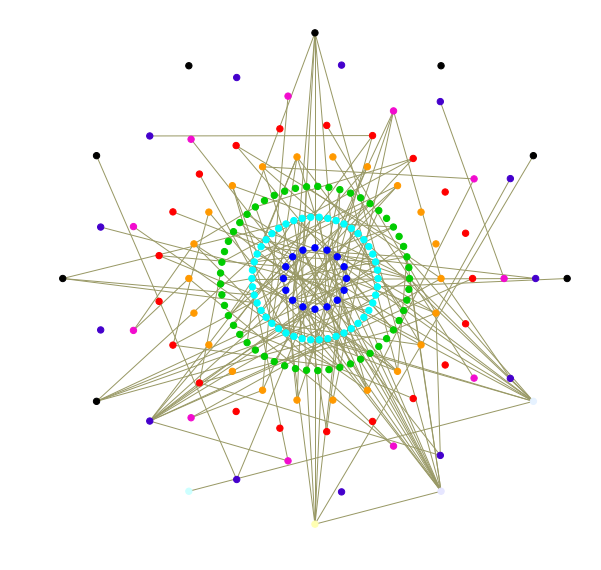

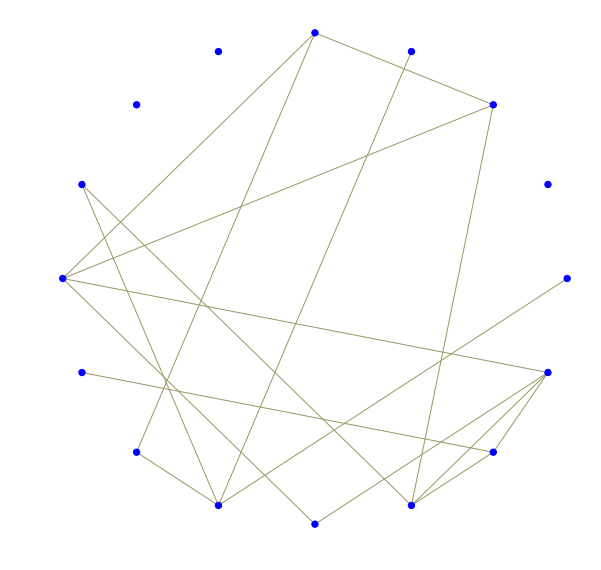

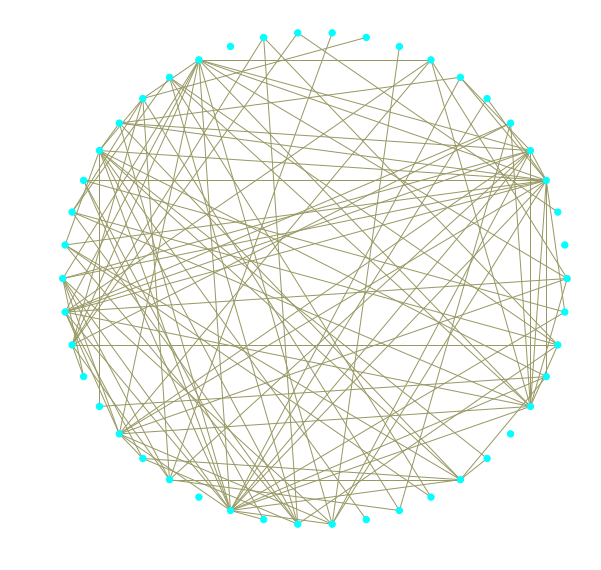

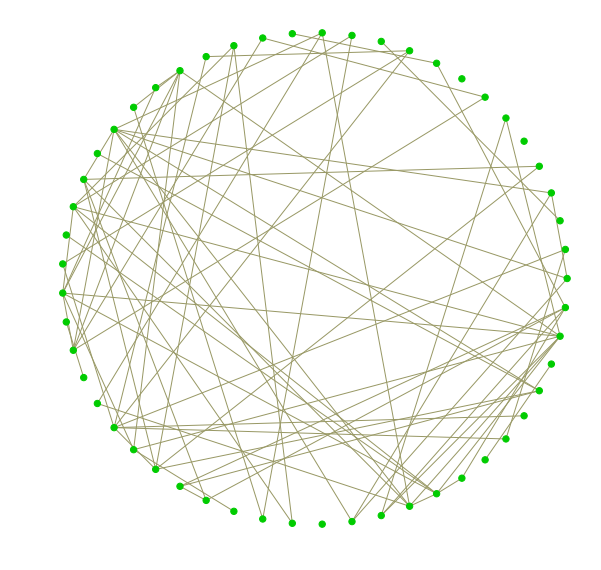

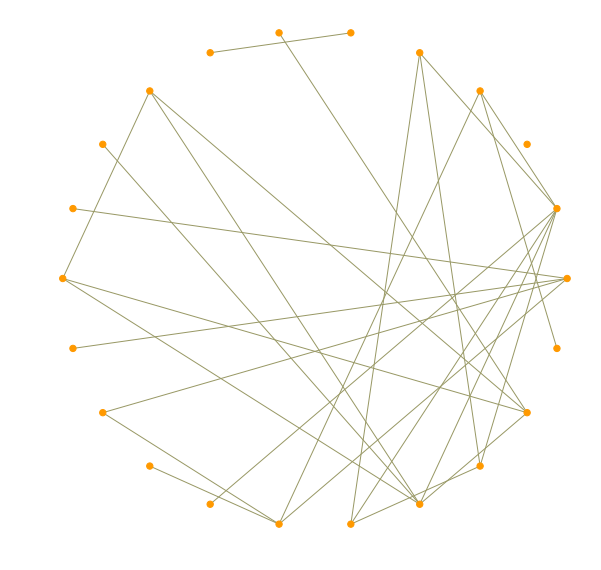

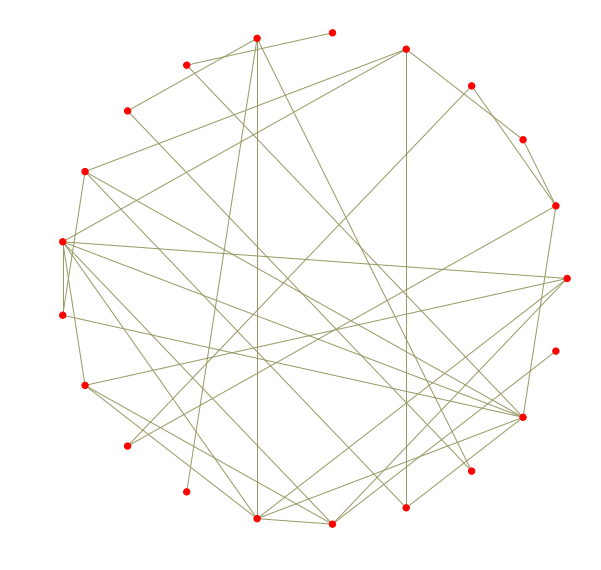

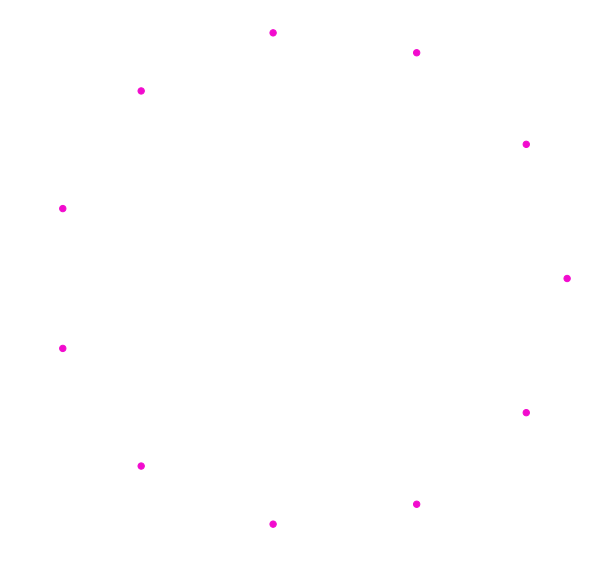

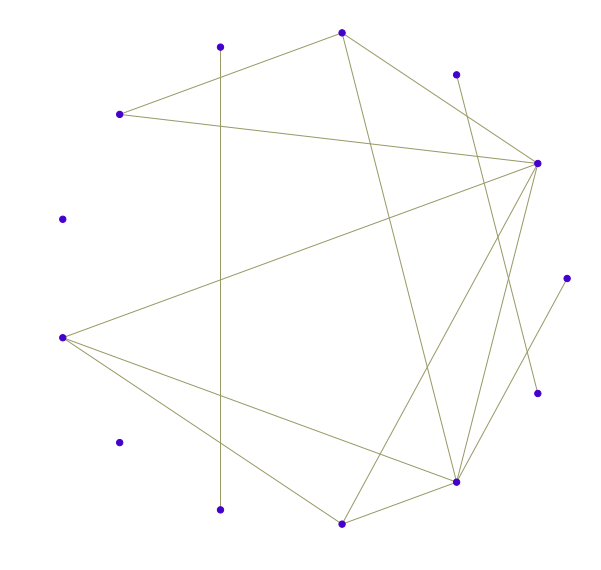

In [30]:
_nlist = [nlist_merged[a] for a in in_school]
_nlist.append(nlist_merged['others'])
fig=plt.figure(figsize=(10,10))
# plot the connection between communities (excluding within the same community) in the first 3,3:
# ax = plt.subplot2grid((6,3), (0,0), colspan=3, rowspan=3)
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only,
    pos=nx.shell_layout(g_poinf_only,_nlist ),
    with_labels=False,
    ax=ax,
    edge_color='#999966',
    node_size=40,
    node_color=color_by_inst(g_poinf_only),
    edgelist=edges) # <- Cross collaborations!

if SAVE_GRAPHS:
    plt.savefig(
        "IMG/infnet20yr_shell_BTW_INST.png",
        format='png',
        bbox_inches="tight",
        transparent=True)

# Draw each institute as a circular list:
row_idx = 3
col_idx = 0
for i in in_school:
    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(111)
#     ax = plt.subplot2grid((6,3),(row_idx,col_idx))
    ax.axis('off')

    g = g_poinf_only.subgraph(nlist_merged[i])
    nx.draw_networkx(
        g,
        pos=nx.circular_layout(g),
        with_labels=False,
        ax=ax,
        edge_color='#999966',
        node_size=40,
        nodelist=nlist_merged[i],
        node_color=color_by_inst(g))
    col_idx += 1
    col_idx = col_idx % 3
    if col_idx == 0:
        row_idx+=1
#     inst = [name for (name, _k) in list(institutes.items()) if _k == k][0]
#     title = "{: <5}".format(inst)
#     ax.set_title(title)
    
    if SAVE_GRAPHS:
        plt.savefig(
            "IMG/infnet20yr_circular_inst_{}.png".format(k),
            format='png',
            bbox_inches="tight",
            transparent=True)
# plt.subplots_adjust()
# plt.tight_layout()


### `Shell Layout`

In [33]:
nlist_merged_list = [nlist_merged[i] for i in in_school]
nlist_merged_list.append(nlist_merged['others'])

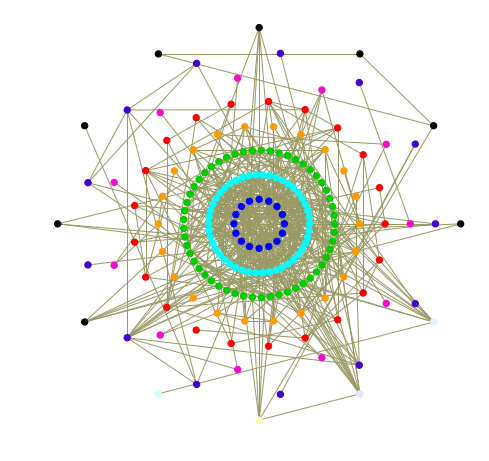

In [34]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only,
    pos=nx.shell_layout(g_poinf_only, nlist_merged_list),
    with_labels=False,
    ax=ax,
    edge_color='#999966',
    node_size=40,
    node_color=color_by_inst(g_poinf_only))

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
#     ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
    #plt.savefig("IMG/infnet20yr_shell.pdf", format='pdf', bbox_inches="tight")
    plt.savefig("IMG/infnet20yr_shell.png", format='png', bbox_inches="tight")

### `Spring Layout`

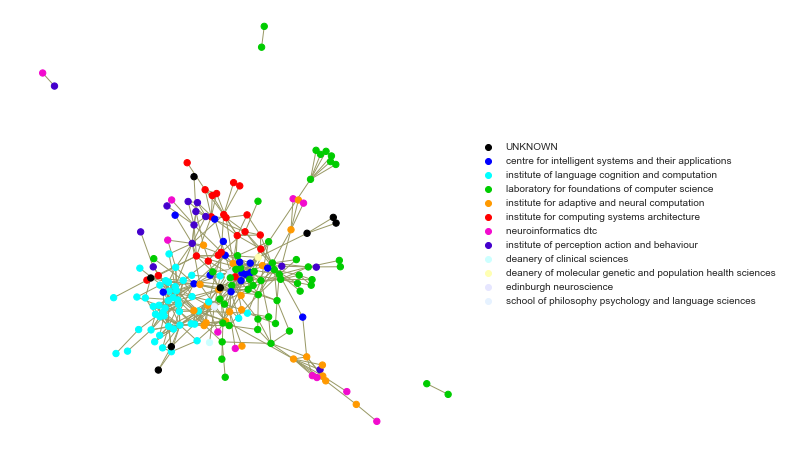

In [35]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only,
    pos=pos,
    with_labels=False,
    ax=ax,
    node_size=40,
    edge_color='#999966',
    node_color=color_by_inst(g_poinf_only))

if SAVE_GRAPHS:
    # ax.set_title('Informatics Collaboration Network from 1997-2017')
    ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
    #plt.savefig("IMG/infnet20yr_spring.pdf", format='pdf', bbox_inches="tight")
    plt.savefig(
        "IMG/infnet20yr_spring.png",
        format='png',
        bbox_inches="tight",
        transparent=True)

#### `3D network graph`

In [33]:
import igraph as ig
from plotly.graph_objs import *
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as offline
offline.init_notebook_mode()

In [34]:
igraph_G = ig.Graph.TupleList(g_poinf_only.edges)
layt = igraph_G.layout('kk', dim=3)
vs = igraph_G.vs

In [35]:
TRACES = []

_data = {}
# VERTICES
for _id in g_poinf_only.nodes:
    _idx = vs.find(_id).index
    _k = lookup_poinf.loc[_id].institute_class  # institute_class of individual
    if _k in list(_data.keys()):
        _data[_k]['Xn'].append(layt[_idx][0])  # x-coordinates
        _data[_k]['Yn'].append(layt[_idx][1])  # y-coordinates
        _data[_k]['Zn'].append(layt[_idx][2])  # z-coordinates
        _data[_k]['ids'].append(_id)
    else:
        _data[_k] = {
            'Xn': [layt[_idx][0]],
            'Yn': [layt[_idx][1]],
            'Zn': [layt[_idx][2]],
            "ids": [_id]
        }

# Scatter nodes
for k in sorted(_data.keys()):
    v = _data[k]
    labels = lookup_poinf.loc[v['ids']].full_name.tolist()
    _trace = Scatter3d(
        x=v['Xn'],
        y=v['Yn'],
        z=v['Zn'],
        mode='markers',
        marker=Marker(
            symbol='dot',
            size=6,
            color=inst_by_color[k],
            line=Line(color='rgb(50,50,50)', width=0.5)),
        text=labels,
        hoverinfo='text',
        showlegend=True,
        name=[n for (n, _k) in list(institutes.items()) if _k == k][0])
    TRACES.append(_trace)

In [36]:
# Scatter edges
# EDGES
Xe, Ye, Ze = [], [], []
vs = igraph_G.vs
for (a, b) in g_poinf_only.edges:
    _a_idx = vs.find(a).index
    _b_idx = vs.find(b).index
    # x-coordinates of edge ends
    Xe += [layt[_a_idx][0], layt[_b_idx][0], None]
    Ye += [layt[_a_idx][1], layt[_b_idx][1], None]
    Ze += [layt[_a_idx][2], layt[_b_idx][2], None]

trace1 = Scatter3d(
    x=Xe,
    y=Ye,
    z=Ze,
    mode='lines',
    line=Line(color='rgb(125,125,125)', width=2),
    hoverinfo="none",
    showlegend=False)
TRACES.append(trace1)

In [37]:
axis = dict(
    showbackground=False,
    showline=False,
    zeroline=False,
    showgrid=False,
    showticklabels=False,
    title="")

In [38]:
layout = Layout(
    title="Informatics Collaboration Network from 1997-2017",
    width=1000,
    height=1000,
    showlegend=True,
    legend=dict(x=0, y=0, xanchor='auto', yanchor='auto'),
    scene=Scene(
        xaxis=XAxis(axis),
        yaxis=YAxis(axis),
        zaxis=ZAxis(axis),
    ),
    margin=Margin(t=50),
    #     hovermode="x",
    #     xaxis={"range":[1997,2017], 'title':'Year'},
    #     sliders={
    #         'args':[
    #             'trainsition', {
    #                 'duration': 400,
    #                 'easing':'cubic-in-out'
    #             }
    #         ],
    #         'initialValue':'1997',
    #         'plotlycommand':'animate',
    #         'values':years,
    #         'visible':True
    #     }
    #     annotations=Annotations([
    #         Annotation(
    #             showarrow=False,
    #             text='Colored by institutes',
    #             xref='paper',
    #             yref='paper',
    #             x=0,
    #             y=0.1,
    #             xanchor='left',
    #             yanchor='bottom',
    #             font=Font(size=14))
    #     ]),
)

In [39]:
data=Data(TRACES)
fig=Figure(data=data, layout=layout)
offline.iplot(fig)

## Collaboration within departments

In this section we visualise each of the seven institutes in School of Informatics
- class 1-centre for intelligent systems and their applications
- class 2-institute of language cognition and computation
- class 3-laboratory for foundations of computer science
- class 4-institute for adaptive and neural computation
- class 5-institute for computing systems architecture
- class 6-neuroinformatics dtc
- class 7-institute of perception action and behaviour

In [39]:
gb_dept = lookup_poinf.groupby('institute_class')

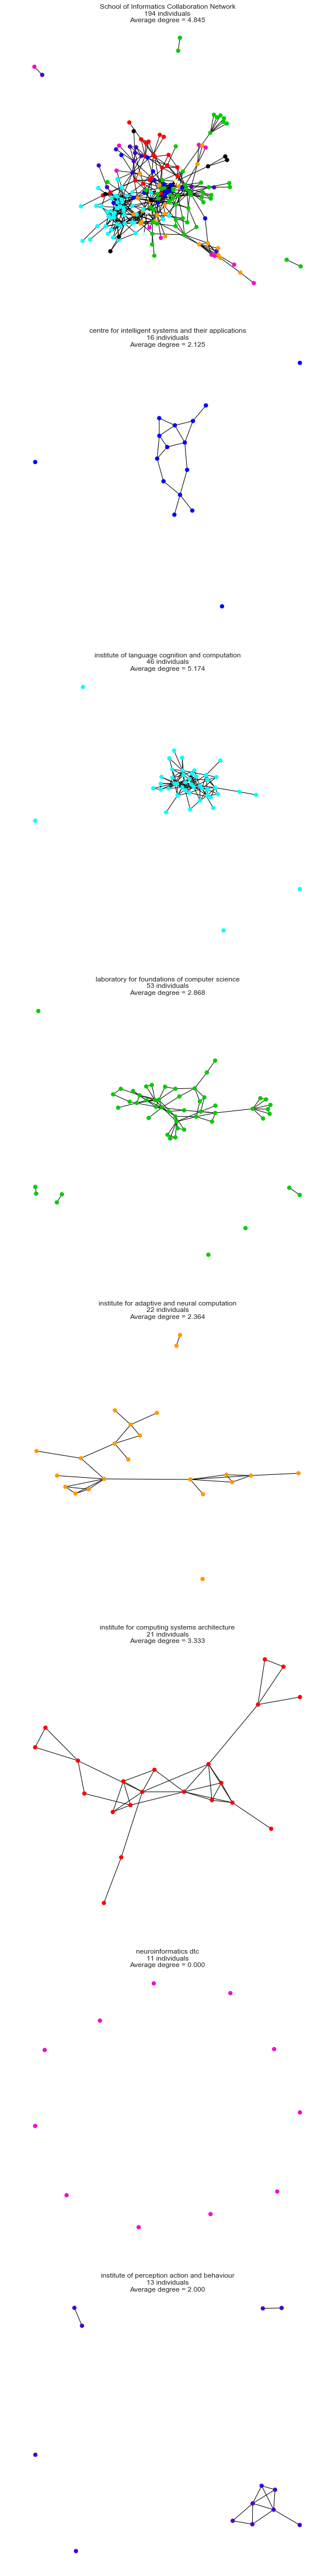

In [40]:
# visualise:
fig = plt.figure(figsize=(9, 80))
ax = fig.add_subplot(8, 1, 1)
ax.axis('off')
ax.set_title(
    'School of Informatics Collaboration Network\n{} individuals\nAverage degree = {:.3f}'.
    format(
        len(g_poinf_only),
        (sum(dict(g_poinf_only.degree).values()) / len(g_poinf_only))))
nx.draw_networkx(
    g_poinf_only,
    pos=pos,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(g_poinf_only))

ks = [1, 2, 3, 4, 5, 6, 7]
for k in ks:
    inst = [name for (name, _k) in list(institutes.items()) if _k == k][0]
    ax = fig.add_subplot(8, 1, k + 1)
    ax.axis('off')
    individuals = gb_dept.get_group(k).index
    g = g_poinf_only.subgraph(individuals)
    nx.draw_networkx(
        g,
        pos=nx.spring_layout(g),
        with_labels=False,
        ax=ax,
        node_size=40,
        nodelist=g.nodes,
        node_color=color_by_inst(g))
    title = "{}\n{} individuals\nAverage degree = {:.3f}".format(
        inst, len(g),
        sum(dict(g.degree).values()) / len(g))
    ax.set_title(title)
    
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_strat_department.pdf", format='pdf', bbox_inches="tight")

## Collaboration across departments
Now, we can calculate collaborative work between departments
1. Using the nodes between any two departments,
2. calculate number of collaboration between departments by removing collaborations between individuals in the department

In [36]:
from itertools import combinations

In [111]:
results = np.zeros([7, 7])
for a, b in combinations(ks, 2):
    count_across_AB = 0
    count_within_A = 0
    count_within_B = 0
    A = list(gb_dept.get_group(a).index)
    B = list(gb_dept.get_group(b).index)
    nodelist = A + B
    collab = g_poinf_only.subgraph(nodelist).edges()
    for (x, y) in collab:
        if (x in A and y in B) or (x in B and y in A):
            count_across_AB += 1  # Count cross collaboration between A and B
        elif (x in A and y in A):
            count_within_A += 1
        elif (x in B and y in B):
            count_within_B += 1
    assert count_within_A + count_within_B + count_across_AB == len(collab)
    # ratio of cross-collaboration between A and B to collaboration within A
    results[a - 1, b - 1] = count_within_A
    # ratio of cross-collaboration between A and B to collaboration within B
    results[b - 1, a - 1] = count_within_B

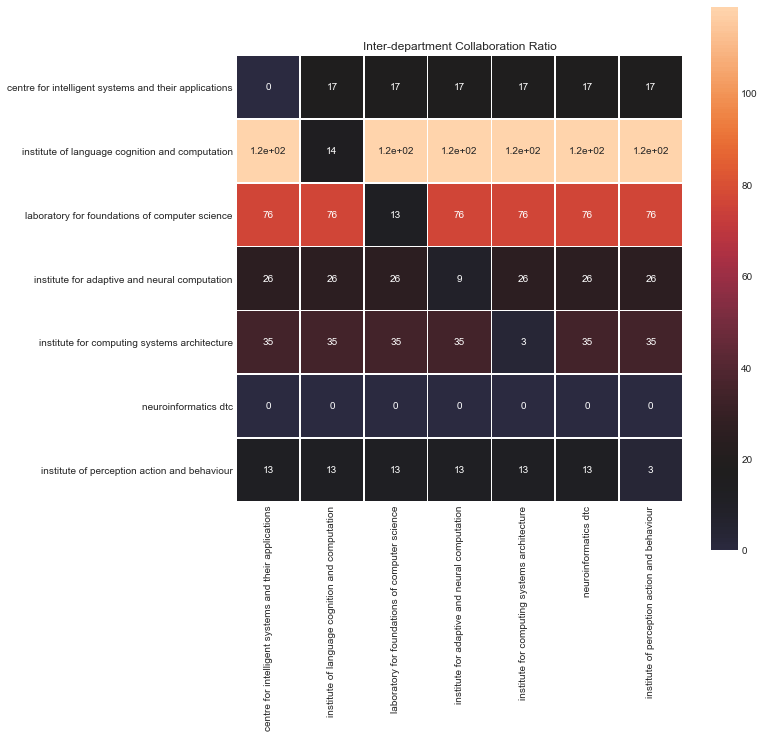

In [112]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

# mask = np.zeros_like(results)
# mask[np.tril_indices_from(mask)] = True
ticks = [[name for (name, _k) in list(institutes.items()) if _k == k][0]
         for k in range(1, 8)]
sns.heatmap(
    results,
#     mask=mask,
    center=np.median(results),
    square=True,
    yticklabels=ticks,
    xticklabels=ticks,
    annot=True,
#     vmax=1,
    robust=True,
    ax=ax,
    linewidths=.5)
ax.set_title('Inter-department Collaboration Ratio')

if SAVE_GRAPHS:
    plt.savefig(
        "IMG/infnet20yr_collab_heatmap.pdf", format='pdf', bbox_inches="tight")

## Development of `infnet` every 5 years

We can now observe the evolution of the informatics network on a time scale of 5 years

In [36]:
years = np.linspace(1997, 2017, num=5, dtype=int)

In [37]:
years

array([1997, 2002, 2007, 2012, 2017])

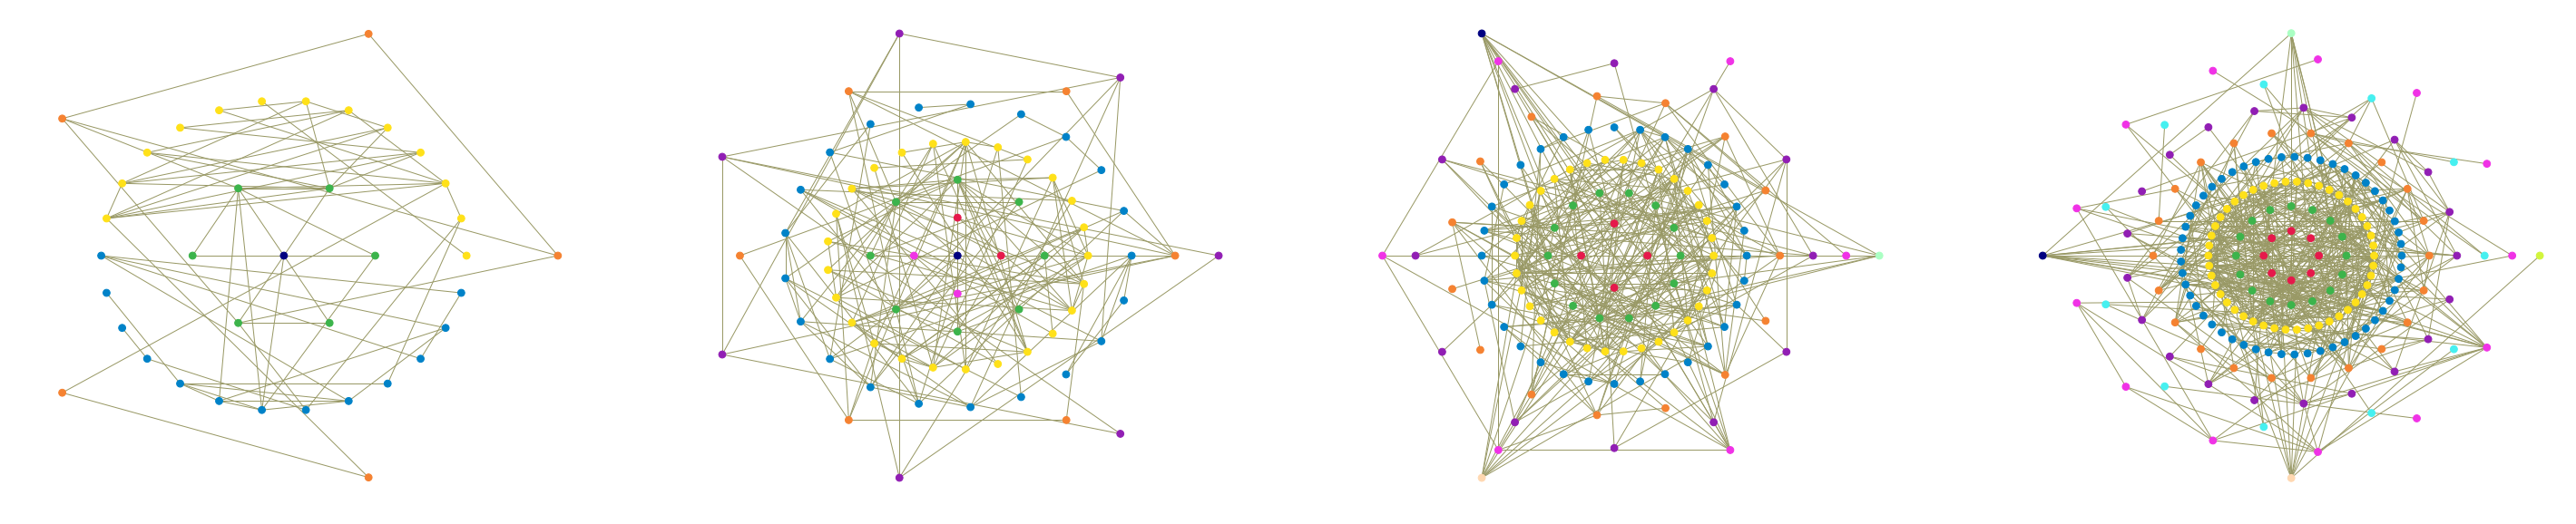

In [38]:
fig = plt.figure(figsize=(50, 10))
i = 1
for yr in years[1:]:
    df = lookup_poinf.drop(
        lookup_poinf[lookup_poinf.first_pub_year > yr].index)
    individuals = list(df.index)
    g = g_poinf_only.subgraph(individuals)
    ax = fig.add_subplot(1, 4, i)
    #     ax.set_title('End of {}'.format(yr))
    ax.axis('off')
    i += 1

    nlist = [[] for i in range(12)]
    for node in g:
        c = int(lookup_poinf.institute_class.loc[[str(node)]])
        nlist[c].append(str(node))
    # sort the list according to the size of the list, so that larger circles are outside.
    nlist_dict = {len(a): [] for a in nlist}
    for lst in nlist:
        nlist_dict[len(lst)].extend(lst)

    length = list(nlist_dict.keys())
    # length.sort(reverse=True)
    _nlist = []
    for l in length:
        _nlist.append(nlist_dict[l])
    _nlist = [a for a in _nlist if len(a) > 0]
    nx.draw_networkx(
        g,
        pos=nx.shell_layout(g, _nlist),
        with_labels=False,
        ax=ax,
        edge_color='#999966',
        node_size=60,
        node_color=color_by_inst(g))
#     nx.draw_networkx(
#         g,
#         pos=pos,
#         with_labels=False,
#         ax=ax,
#         node_size=40,
#         nodelist=g.nodes,
#         node_color=color_by_inst(g))

if SAVE_GRAPHS:
    #         fig.suptitle('Evolution of Informatics Collaboration Network (1997-2017)')
    #         plt.savefig("IMG/infnet20yr_evolution.pdf", format='pdf', bbox_inches="tight")
    plt.savefig(
        "IMG/infnet20yr_evolution.png",
        format='png',
        bbox_inches="tight",
        transparent=True)

## Statistics

In [114]:
from helper import *  # Helper functions!

### Degree distribution

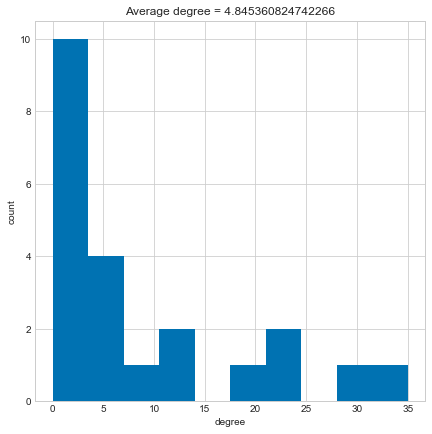

In [115]:
ax, degree_seq = degree_dist(g_poinf_only)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


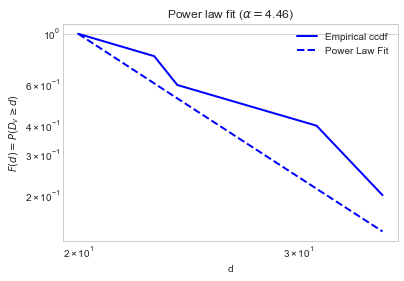

In [116]:
# we can observe the power-law fit to our degree distribution:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_degreeDist.pdf", format='pdf', bbox_inches="tight")

ideally, a log-log plot on the ccdf with power-law should yield a straight line

### Clustering coefficients

In [117]:
cc = clustering_coeff(g_poinf_only)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.369063959421752


In [118]:
# The number of triangles for each nodes
transitivity_graph = nx.transitivity(g_poinf_only)
print('Transitivity:', transitivity_graph)

Transitivity: 0.3079150579150579


### Connected components

In [119]:
gccs, percentage = generateGCC(g_poinf_only)

component 1: 96.91%
component 2: 1.03%
component 3: 1.03%
component 4: 1.03%


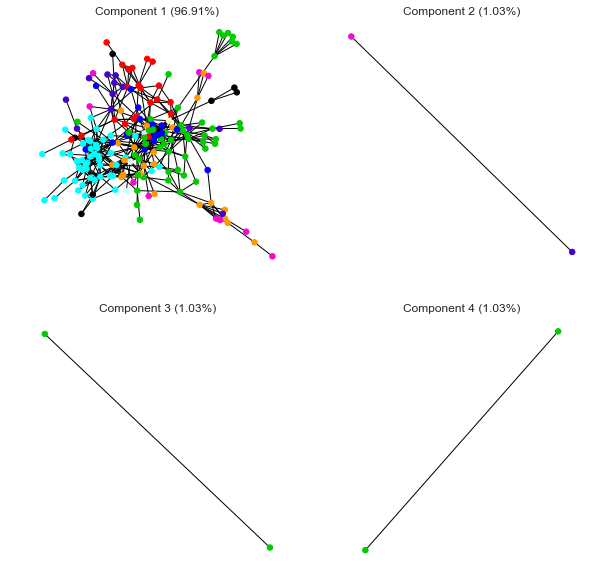

In [120]:
# display the connected components:
fig = plt.figure(figsize=(10, 10))
num_col = len(gccs) / 2
for i, g in enumerate(gccs, 1):
    percent = percentage[i - 1]
    ax = fig.add_subplot(num_col, 2, i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=30,
        pos=pos)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_CC.pdf", format='pdf', bbox_inches="tight")

## Giant Connected Component
Now, we analyse the giant connected component from the network

In [121]:
main_gcc = gccs[0]  # First element is our GCC as we have sorted in reverse
pos_gcc = nx.spring_layout(main_gcc)

In [122]:
print('number of nodes in largest connected component:', len(main_gcc))

number of nodes in largest connected component: 188


In [123]:
print(nx.info(main_gcc))

Name: 
Type: Graph
Number of nodes: 188
Number of edges: 467
Average degree:   4.9681


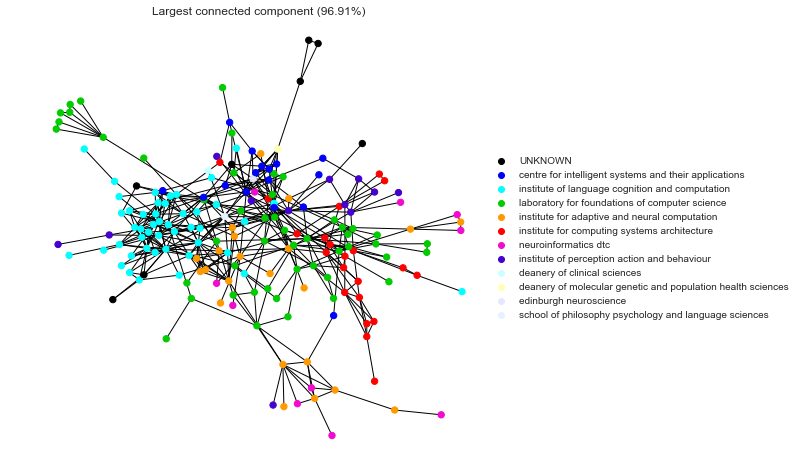

In [124]:
# Draw the Network
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(main_gcc))
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]))
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet20yr_LargestCC.pdf", format='pdf', bbox_inches="tight")

#### Degree Distribution

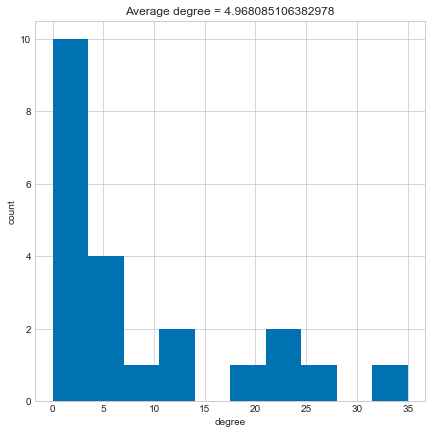

In [125]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


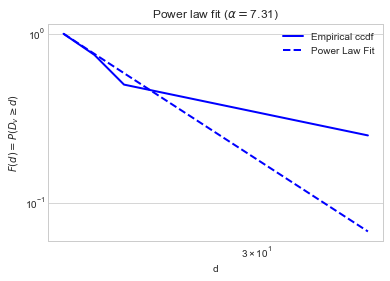

In [126]:
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig(
        "IMG/infnet20yr_LargestCC-degreeDist.pdf", format='pdf', bbox_inches="tight")

#### Clustering Coefficient

In [67]:
cc = clustering_coeff(main_gcc)

In [68]:
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.3808425964245739


#### Average Path & Diameter

In [69]:
nx.average_shortest_path_length(main_gcc)  # AVERAGE PATH

4.065365798156787

In [70]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 10


#### Community detection

In [71]:
import community

In [ ]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]
# assign each node to the community they belong to

In [ ]:
# Plot the networks side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=40,
    node_color=color_by_inst(main_gcc))
ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=40,
    with_labels=False)
plt.savefig(
    "IMG/infnet_LargestCC_commCompare.pdf", format='pdf', bbox_inches="tight")

In [ ]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

In [ ]:
# plot each community:
fig = plt.figure(figsize=(10, 30))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(6, 2, i)
    # find those nodes belonging to this community:
    nodes_from_comm = [
        node_id for (node_id, c) in parts.items() if c == comm_id
    ]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))

    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(nodes_from_comm),
        node_size=20,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig(
    "IMG/infnet_LargestCC_communities.pdf", format='pdf', bbox_inches="tight")

#### Influential individuals
Using betweness centrality as a mean to measure influence of node in the network

In [ ]:
bt = between_parallel(main_gcc)

In [ ]:
top = 11

In [ ]:
# we need to find the index of these max_nodes:
_nodes = list(main_gcc.nodes())

In [ ]:
max_nodes = sorted(bt.items(), key=lambda v: -v[1])[:top]
max_nodes

In [ ]:
# variables for plotting the network: values tell nx how big each node should be
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (
        max_val * 150)**2.2  # SCALE IT ACCORDINGLY
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
plt.savefig("IMG/infnet_influencer.pdf", format='pdf', bbox_inches="tight")

In [ ]:
top_ids = [a[0] for a in max_nodes]

In [ ]:
pd_poinf.loc[top_ids]

## Embedding

#### Embedding: `TF-IDF`

In [24]:
sim_mat_tfidf = np.load(
    os.path.join(DATA_DIR, 'mat', 'tfidf_embedding_bin.pkl'))

In [25]:
# We are only interested in individuals in the collab graph:
poinf_ids = pd.read_csv(
    os.path.join(DATA_DIR, 'poinf_collabgraph_1997-2017.txt'),
    sep='\n',
    names=['id'])
df_pubmapping = pd.read_pickle(
    os.path.join(DATA_DIR, 'poinf_to_pub_mapping.pkl'))
# merge the two dataframes, so that those that we are not interested are excluded:
df_pubmapping.set_index('id', inplace=True)
poinf_ids.set_index('id', inplace=True)
df_pubmapping_4_collabgraph = poinf_ids.join(df_pubmapping, how='left')

In [26]:
# Convert to graph representation
g_tfidf_embedding = nx.Graph()
names = df_pubmapping_4_collabgraph.index.tolist()
for i in range(len(names)):
    for j in range(len(names)):
        if sim_mat_tfidf[i][j] > 0:
            g_tfidf_embedding.add_edge(names[i], names[j])

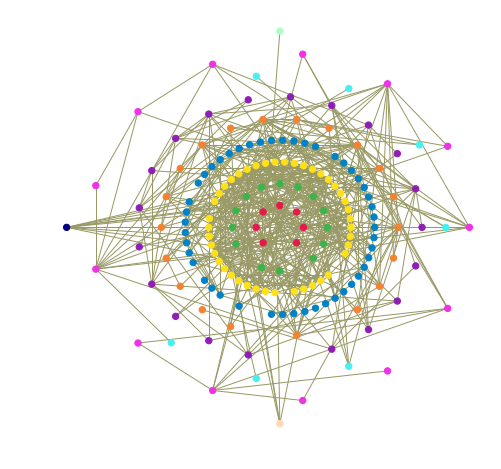

In [42]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_tfidf_embedding,
    pos=nx.shell_layout(g_tfidf_embedding, _nlist),
    with_labels=False,
    ax=ax,
    edge_color='#999966',
    node_size=40,
    node_color=color_by_inst(g_tfidf_embedding))

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
#     ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
    #plt.savefig("IMG/infnet20yr_shell.pdf", format='pdf', bbox_inches="tight")
    plt.savefig("IMG/infnet20yr_shell_tfidf_embedding.png", format='png', bbox_inches="tight")

#### Embedding: `topic model 2`

In [43]:
sim_mat_model2 = np.load(
    os.path.join(DATA_DIR, 'mat', 'tm_model2_embedding_bin.pkl'))

In [44]:
# Convert to graph representation
g_model2_embedding = nx.Graph()
names = df_pubmapping_4_collabgraph.index.tolist()
for i in range(len(names)):
    for j in range(len(names)):
        if sim_mat_model2[i][j] > 0:
            g_model2_embedding.add_edge(names[i], names[j])

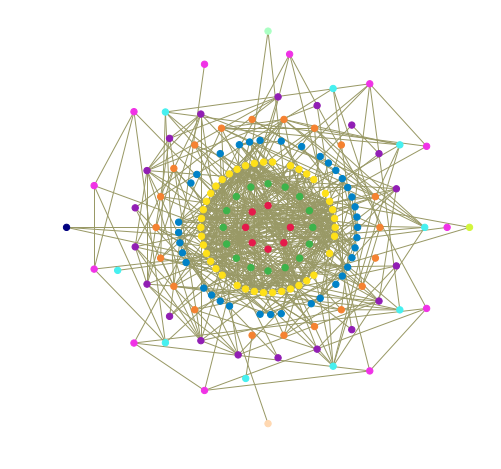

In [45]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_model2_embedding,
    pos=nx.shell_layout(g_model2_embedding, _nlist),
    with_labels=False,
    ax=ax,
    edge_color='#999966',
    node_size=40,
    node_color=color_by_inst(g_model2_embedding))

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
#     ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
    #plt.savefig("IMG/infnet20yr_shell.pdf", format='pdf', bbox_inches="tight")
    plt.savefig("IMG/infnet20yr_shell_model2_embedding.png", format='png', bbox_inches="tight")

In [51]:
print(nx.info(g_model2_embedding))

Name: 
Type: Graph
Number of nodes: 164
Number of edges: 467
Average degree:   5.6951


#### Embedding: `DBLP`

In [46]:
sim_mat_dblp = np.load(
    os.path.join('../../data/data_dblp/', 'mat', 'tm_dblp_embedding_bin.pkl'))

In [52]:
# Convert to graph representation
g_dblp_embedding = nx.Graph()
names = df_pubmapping_4_collabgraph.index.tolist()
for i in range(len(names)):
    for j in range(len(names)):
        if sim_mat_dblp[i][j] > 0:
            g_dblp_embedding.add_edge(names[i], names[j])

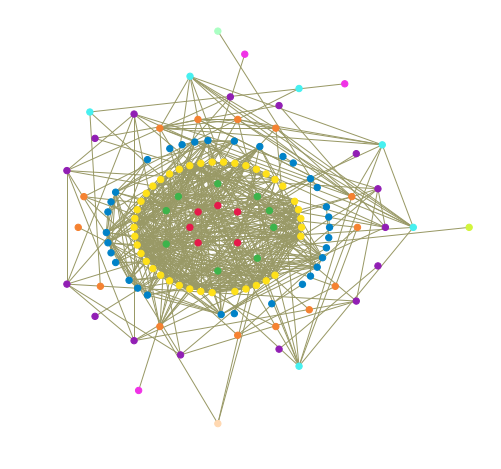

In [53]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_dblp_embedding,
    pos=nx.shell_layout(g_dblp_embedding, _nlist),
    with_labels=False,
    ax=ax,
    edge_color='#999966',
    node_size=40,
    node_color=color_by_inst(g_dblp_embedding))

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
#     ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
    #plt.savefig("IMG/infnet20yr_shell.pdf", format='pdf', bbox_inches="tight")
    plt.savefig("IMG/infnet20yr_shell_dblp_embedding.png", format='png', bbox_inches="tight")

In [54]:
print(nx.info(g_dblp_embedding))

Name: 
Type: Graph
Number of nodes: 129
Number of edges: 473
Average degree:   7.3333


# 6yr Model :: 2012-2017

## Setup `lookup_pub`

In [12]:
# What are the years?
print(sorted(pd.unique(lookup_pub_sorted_yrs.year), reverse=True))

NameError: name 'lookup_pub_sorted_yrs' is not defined

In [ ]:
# There are some dates instead of just purely years.
# they all fall out of the 6 year period that we are interestted in (2017-2012)
# Grouping the publications by year:
gb = lookup_pub_sorted_yrs.groupby('year')
sixYears = [2017, 2016, 2015, 2014, 2013, 2012]
pd_years = {}
print("Year:\tPub count")
for yr, group in gb:
    if yr in sixYears:
        pd_years[yr] = group
        print("{}:\t{}".format(yr, len(group)))

In [125]:
combined_yrs = pd.concat(pd_years.values())
print("Total publications: ", len(combined_yrs))

Total publications:  656


In [126]:
all_edges_6yr = []
for listEdges in combined_yrs.edges:
    all_edges_6yr.extend(listEdges)
print('total number of edges: ', len(all_edges_6yr))

total number of edges:  9062


In [127]:
# Since the graph of interest is simple ud, we remove all repeated edges
unique_edges_6yr = set()
for (i1, i2) in all_edges_6yr:
    assert i1 != i2, "SELF LOOPS DETECTED!"

    # We are only interested in an simple undirected graph!
    # if the same edge exists, we can ignore
    if (i2, i1) in unique_edges_6yr:
        continue
    else:
        # adding another (i1,i2) into the set will only count as one
        unique_edges_6yr.add((i1, i2))

In [128]:
print('number of unique edge pairs: ', len(unique_edges_6yr))

number of unique edge pairs:  6053


In [129]:
# Filter all edges pairs if there is only one or none individuals from school of informatics
poinf6yr_edges_only = [(au1, au2) for (au1, au2) in unique_edges_6yr
                       if au1 in lookup_poinf.index and au2 in lookup_poinf.index]

In [130]:
print('size of collaboration network (number of edges): ',
      len(poinf6yr_edges_only))

size of collaboration network (number of edges):  360


Note the large decrease in edges with and without external individuals (from 19,890 to 360)

## Graphing Infnet (6yr model)

In [131]:
g_poinf_only_6yr = nx.from_edgelist(poinf6yr_edges_only)
pos_6yr = nx.spring_layout(g_poinf_only_6yr,random_state=rng)

In [132]:
print(nx.info(g_poinf_only_6yr))

Name: 
Type: Graph
Number of nodes: 183
Number of edges: 360
Average degree:   3.9344


### Adjacency Matrix

In [53]:
# To ensure that the id corresponding to each individual is the same as for those, 
# First, create a dump of the id that corresponds to the list of individual:
adjacency = nx.adjacency_data(g_poinf_only_6yr)['adjacency']
nodelist = [a['id'] for a in nx.adjacency_data(g_poinf_only_6yr)['nodes']]
with open(os.path.join(DATA_DIR, 'poinf_collabgraph_2012-2017.txt'), 'w') as f:
          f.write("\n".join(nodelist))

In [54]:
len(nodelist)

183

In [55]:
# create empty matrix that preserves the order that nodes are being added
# This is useful when comparing the output....
adj_mat = np.zeros([len(nodelist),len(nodelist)])
for i, node in enumerate(nodelist):
    # given since the lookup_poinf has already been filtered if first_pub_year exists
    neighbours = [n for n in g_poinf_only_6yr[node]] 
    for neighbour in neighbours:
        idx = nodelist.index(neighbour)
        adj_mat[i][idx] = 1

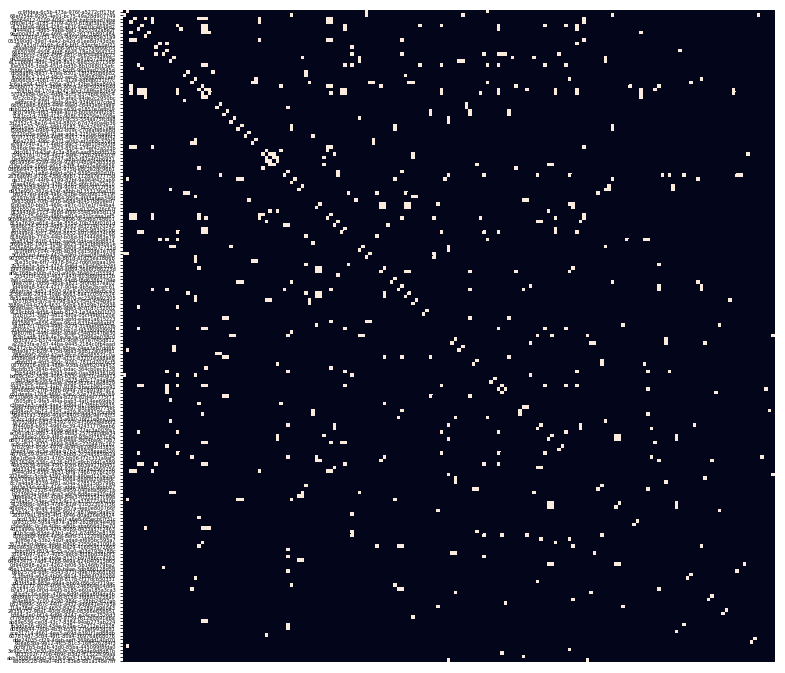

In [56]:
fig = plt.figure(figsize=(13, 12))
ax = fig.add_subplot(111)
sns.heatmap(adj_mat, square=True, yticklabels=nodelist, xticklabels="", ax=ax, cbar=False)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(5) 
plt.savefig('IMG/infnet6yr_adj_mat.png', format='png', transparent=True, bbox_inches='tight')

In [57]:
# save the mat:
adj_mat.dump(os.path.join(DATA_DIR, 'mat','infnet6yrs-adj-mat.pkl'))

### `Circular Layout` for each class

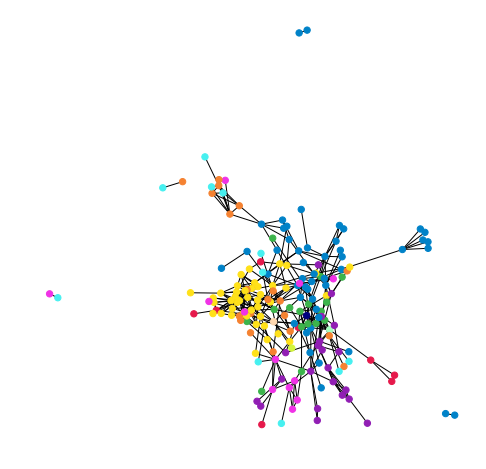

In [76]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

ax.axis('off')
nx.draw_networkx(
    g_poinf_only_6yr,
    pos=pos,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(g_poinf_only_6yr))
if SAVE_GRAPHS:
    #ax=add_inst_labels(ax)
    #plt.savefig("IMG/infnet6yr_full_graph.pdf", format='pdf', bbox_inches="tight")
    plt.savefig("IMG/infnet6yr_full_graph.png", format='png', bbox_inches="tight", transparent=True)

### Shell Layout

In [58]:
nlist = [[] for i in range(12)]
for node in g_poinf_only_6yr:
    c = int(lookup_poinf.institute_class.loc[[str(node)]])
    nlist[c].append(str(node))
# sort the list according to the size of the list, so that larger circles are outside.
nlist_dict = {len(a):[] for a in nlist}
for lst in nlist:
    nlist_dict[len(lst)].extend(lst)
    
length = list(nlist_dict.keys())
# length.sort(reverse=True)
_nlist = []
for l in length:
    _nlist.append(nlist_dict[l])
_nlist = [a for a in _nlist if len(a)>0]

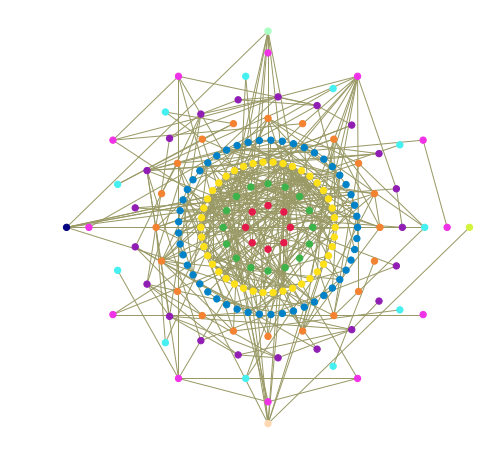

In [59]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_poinf_only_6yr,
    pos=nx.shell_layout(g_poinf_only_6yr, _nlist),
    with_labels=False,
    ax=ax,
    edge_color='#999966',
    node_size=40,
    node_color=color_by_inst(g_poinf_only_6yr))

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
#     ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
#     plt.savefig("IMG/infnet6yr_shell.pdf", format='pdf', bbox_inches="tight")
    plt.savefig("IMG/infnet6yr_shell.png", format='png', bbox_inches="tight",transparent=True, )

In [124]:
print(nx.info(g_poinf_only_6yr))

Name: 
Type: Graph
Number of nodes: 183
Number of edges: 360
Average degree:   3.9344


## Statistics

### Degree distribution

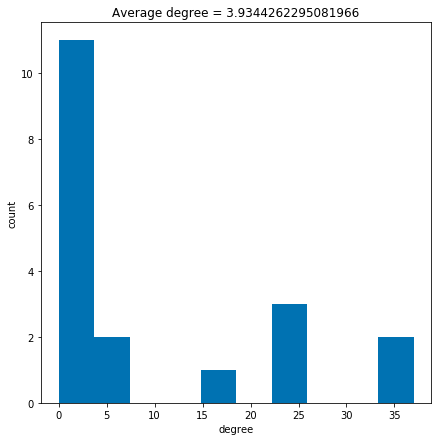

In [125]:
ax, degree_seq = degree_dist(g_poinf_only_6yr)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning:

invalid value encountered in true_divide



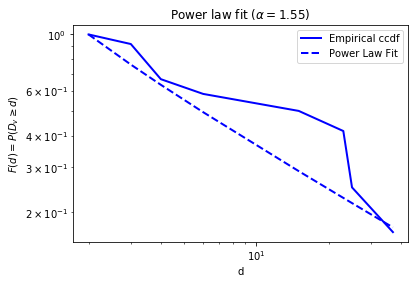

In [126]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet6yr_degreeDist.pdf", format='pdf', bbox_inches="tight")

### Clustering coefficient

In [127]:
cc = clustering_coeff(g_poinf_only_6yr)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.42507862061864


In [128]:
# The number of triangles for each nodes
transitivity_graph = nx.transitivity(g_poinf_only_6yr)
print('Transitivity:', transitivity_graph)

Transitivity: 0.3979591836734694


### Connected Components

In [129]:
gccs, percentage = generateGCC(g_poinf_only_6yr)

component 1: 94.54%
component 2: 1.09%
component 3: 1.09%
component 4: 1.09%
component 5: 1.09%
component 6: 1.09%


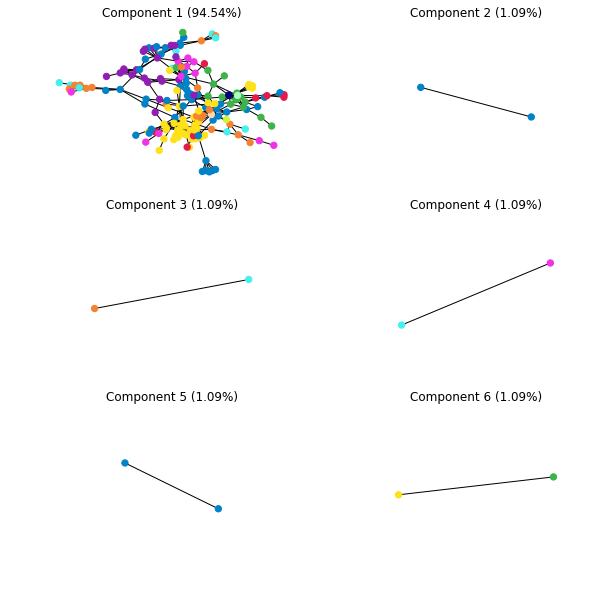

In [130]:
# display the connected components:
fig = plt.figure(figsize=(10, 10))
num_col = len(gccs) / 2
for i, g in enumerate(gccs, 1):
    percent = percentage[i - 1]
    ax = fig.add_subplot(num_col, 2, i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=40,
        pos=pos_6yr)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet6yr_CC.pdf", format='pdf', bbox_inches="tight")

## Giant Connected Component

In [132]:
main_gcc = gccs[0]
pos_gcc = nx.spring_layout(main_gcc, random_state=rng)

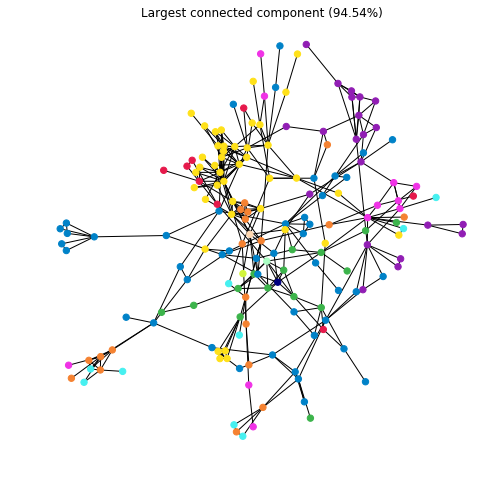

In [136]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=40,
    node_color=color_by_inst(main_gcc)
)
if SAVE_GRAPHS:
    ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]));
    plt.savefig("IMG/infnet6yr_LargestCC.pdf", format='pdf', bbox_inches="tight")
    

In [137]:
print('number of nodes in largest connected component:', len(main_gcc))
print(nx.info(main_gcc))

number of nodes in largest connected component: 173
Name: 
Type: Graph
Number of nodes: 173
Number of edges: 355
Average degree:   4.1040


### Degree distribution

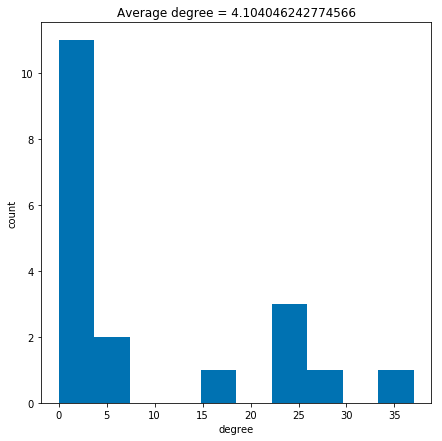

In [138]:
ax, degree_seq = degree_dist(main_gcc)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/weiting/miniconda3/envs/infnet3/lib/python3.6/site-packages/powerlaw.py:697: RuntimeWarning:

invalid value encountered in true_divide



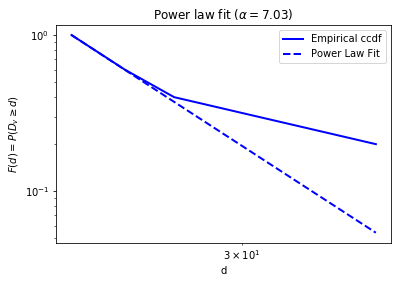

In [139]:
# $F(d) = (\frac{d}{d_{min}})^{-(\alpha-1)}$
fig = power_law_fit(degree_seq)
if SAVE_GRAPHS:
    plt.savefig("IMG/infnet6yr_LargestCC_degreeDist.pdf", format='pdf', 
            bbox_inches="tight")

### Clustering Coefficient

In [140]:
cc = clustering_coeff(main_gcc)
print('average clustering coefficient: ', cc[1])

average clustering coefficient:  0.44964963915150924


### Average Path & Diameter

In [141]:
nx.average_shortest_path_length(main_gcc) # AVERAGE PATH

4.986490119639736

In [142]:
# Diameter:
print('Diameter of graph:', nx.diameter(main_gcc))

Diameter of graph: 11


### Community detection

In [ ]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]  
# assign each node to the community they belong to

In [ ]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)')
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=40,
    node_color=color_by_inst(main_gcc)
)


ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=40,
    with_labels=False)
plt.savefig("IMG/infnet6yr_LargestCC_commCompare.pdf", format='pdf', 
            bbox_inches="tight")

In [ ]:
num_comm = len(set(parts.values()))
print('Number of communities detected =', num_comm)

In [ ]:
# plot each community:
fig = plt.figure(figsize=(10,30))
comms = set(parts.values())
for i, comm_id in enumerate(comms, 1):
    ax = fig.add_subplot(6,2,i)
    # find those nodes belonging to this community:
    nodes_from_comm = [node_id for (node_id, c) in parts.items() if c == comm_id]
    # Generate the subgrph belonging to these nodes:
    subG = nx.subgraph(main_gcc, nodes_from_comm)
    ax.axis('off')
    ax.set_title('Community {}'.format(comm_id))
    
    nx.draw_networkx(
        subG,
        pos=pos_gcc,
        ax=ax,
        node_color=color_by_inst(nodes_from_comm),
        node_size=40,
        with_labels=False)
ax = add_inst_labels(ax)
plt.savefig("IMG/infnet6yr_LargestCC_communities.pdf", format='pdf', 
            bbox_inches="tight")

### Influential individuals

In [ ]:
bt = between_parallel(main_gcc)

In [ ]:
top = 11

In [ ]:
# we need to find the index of these max_nodes:
_nodes = list(main_gcc.nodes())

In [ ]:
max_nodes = sorted(bt.items(), key=lambda v: -v[1])[:top]
max_nodes

In [ ]:
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (max_val * 150)**2.2
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
plt.savefig("IMG/infnet6yr_influencer.pdf", format='pdf', 
            bbox_inches="tight")

In [ ]:
top_ids = [a[0] for a in max_nodes]
pd_poinf.loc[top_ids]

# Weighted 6yr Model
IN this section, we explore a version of the weight simple undirected grap of the 6yr model.
The calculation of the weight of an edge is the sum of contributions by each author pair for all their publications (publication which involve both of them (and others).

Contributions are calculated as $$\text{contribution}(u,v) = \frac{1}{\text{size of complete graph}} = \frac{1}{{N}\choose{2}} = \frac{1}{\frac{N(N-1)}{2}} = \frac{2}{N(N-1)}$$ where $N$ is the number of authors for a publication.

Weight of edge between authors $u$ and $v$ 
$$weight(u,v) = \sum_{i=1}^{N}\text{contribution}_{i}(u,v)$$

## Setup

In [81]:
def get_edge_weight(authors):
    # function to calculate the edge weight for each publication
    if len(authors) > 1:
        n = len(authors)
        k = 2. / (n * (n - 1))
    else:
        k = 0.
    return k

In [82]:
combined_yrs['weight'] = combined_yrs.apply(
    lambda row: get_edge_weight(row.collab_id), axis=1)

In [83]:
combined_yrs.iloc[10]

year                                                       2012
authors       c. pagliari|c. burton|b. mckinstry|a. szentato...
shortnames    pagliari, c.|burton, c.|mckinstry, b.|szentato...
collab_id     [5787, 897, 6310, 53, 3644, 7540, 1065, 5978, ...
edges         [(5787, 897), (5787, 6310), (5787, 53), (5787,...
weight                                                0.0181818
Name: a885ba37-e8ec-419e-8963-d1a72cfbff34, dtype: object

In [84]:
# Add the edges to the network with weight attribute
g_poinf_weighted = nx.Graph()
for row in combined_yrs.itertuples():
    edgelist = row.edges
    weight = row.weight
    for (a, b) in edgelist:
        if a in lookup_poinf.index and b in lookup_poinf.index:
            g_poinf_weighted.add_edge(a, b, weight=weight)

In [85]:
edgewidth = [
    d['weight'] * 2. for (u, v, d) in g_poinf_weighted.edges(data=True)
]  # weights for each edges
print(nx.info(g_poinf_weighted))

Name: 
Type: Graph
Number of nodes: 183
Number of edges: 360
Average degree:   3.9344


In [86]:
assert not set(g_poinf_only_6yr.nodes).difference(
    set(g_poinf_weighted.nodes
        )), "Same number of nodes for both 6yr model should be observer"

### Adjacency matrix

In [72]:
# To ensure that the id corresponding to each individual is the same as for those,
# First, create a dump of the id that corresponds to the list of individual:
adjacency = nx.adjacency_data(g_poinf_weighted)['adjacency']
nodelist = [a['id'] for a in nx.adjacency_data(g_poinf_weighted)['nodes']]
with open(
        os.path.join(DATA_DIR, 'poinf_collabgraph_2012-2017_weighted.txt'),
        'w') as f:
    f.write("\n".join(nodelist))

In [73]:
len(nodelist)

183

In [75]:
# create empty matrix that preserves the order that nodes are being added
# This is useful when comparing the output....
adj_mat = np.zeros([len(nodelist),len(nodelist)])
for i, node in enumerate(nodelist):
    # given since the lookup_poinf has already been filtered if first_pub_year exists
    for neighbour_id, props in g_poinf_weighted[node].items():
        idx = nodelist.index(neighbour_id)
        adj_mat[i][idx] = props['weight']

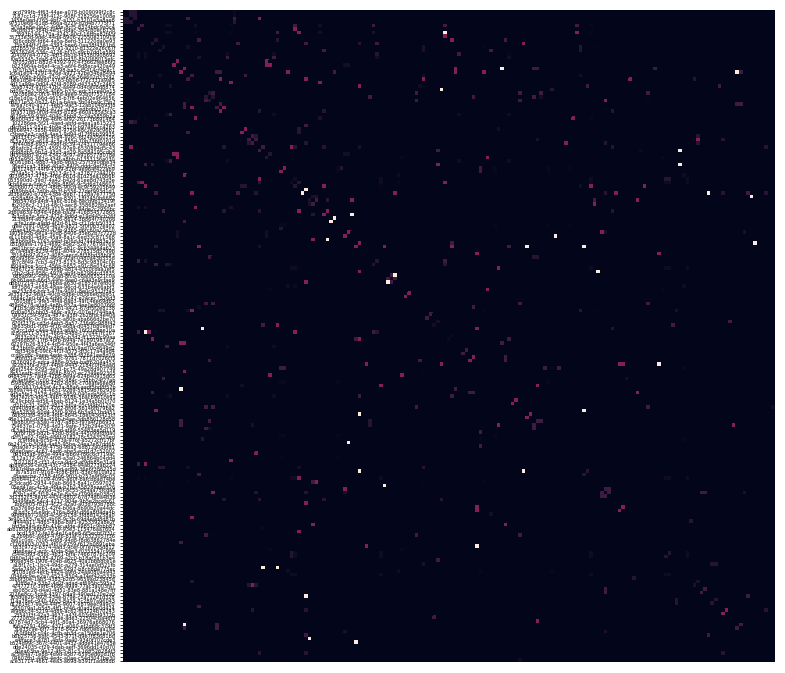

In [77]:
fig = plt.figure(figsize=(13, 12))
ax = fig.add_subplot(111)
sns.heatmap(adj_mat, square=True, yticklabels=nodelist, xticklabels="", ax=ax, cbar=False)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(5) 
plt.savefig('IMG/infnet6yrw_adj_mat.png', format='png', transparent=True, bbox_inches='tight')

In [117]:
# save the weighted matrix:
adj_mat.dump(os.path.join(DATA_DIR,'mat','infnet6yrs-weighted-adj-mat.pkl'))

(array([36., 34.,  6., 34., 17.,  0., 15.,  0.,  0., 54.,  0.,  0.,  0.,
         0.,  0.,  0., 81.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 64.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.]),
 array([0.00724638, 0.02717391, 0.04710145, 0.06702899, 0.08695652,
        0.10688406, 0.12681159, 0.14673913, 0.16666667, 0.1865942 ,
        0.20652174, 0.22644928, 0.24637681, 0.26630435, 0.28623188,
        0.30615942, 0.32608696, 0.34601449, 0.36594203, 0.38586957,
        0.4057971 , 0.42572464, 0.44565217, 0.46557971, 0.48550725,
        0.50543478, 0.52536232, 0.54528986, 0.56521739, 0.58514493,
        0.60507246, 0.625 

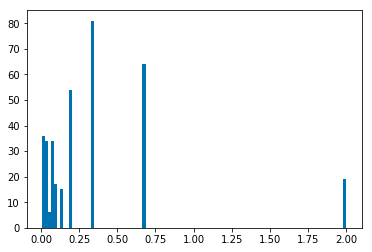

In [118]:
# Take a look at the distribution of edgewidth
plt.hist(edgewidth, bins=100)
# plt.savefig('IMG/infnet6yrw_tofWeights.pdf', format='pdf', bbbox_inches="tight")

### Graphing Weighted Network

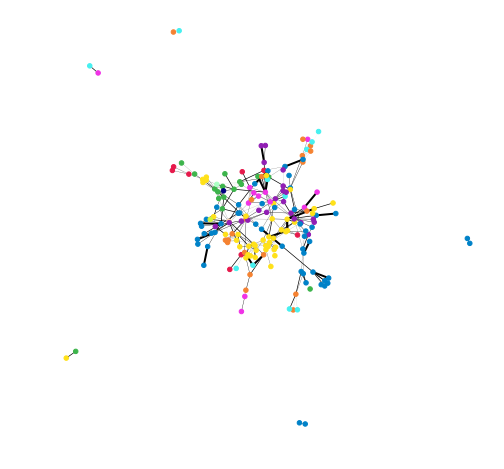

In [87]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax=add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx_nodes(
    g_poinf_weighted,
    pos=pos_6yr,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(g_poinf_weighted))
nx.draw_networkx_edges(
    g_poinf_weighted,
    pos_6yr,
    width=edgewidth,
)
if SAVE_GRAPHS:
    plt.savefig(
        "IMG/infnet6yrw_full_graph.pdf", format='pdf', bbox_inches="tight")

In [88]:
nlist = [[] for i in range(12)]
for node in g_poinf_weighted:
    c = int(lookup_poinf.institute_class.loc[[str(node)]])
    nlist[c].append(str(node))
    
# sort the list according to the size of the list, so that larger circles are outside.
nlist_dict = {len(a):[] for a in nlist}
for lst in nlist:
    nlist_dict[len(lst)].extend(lst)
    
length = list(nlist_dict.keys())
# length.sort(reverse=True)
_nlist = []
for l in length:
    _nlist.append(nlist_dict[l])
_nlist = [a for a in _nlist if len(a)>0]

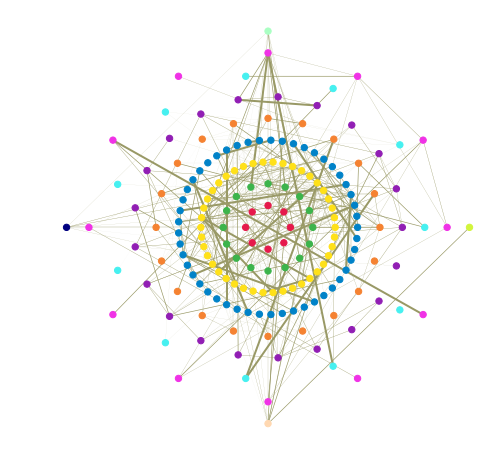

In [90]:
# visualise:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.axis('off')
nx.draw_networkx(
    g_poinf_weighted,
    pos=nx.shell_layout(g_poinf_weighted, _nlist),
    with_labels=False,
    ax=ax,
    edge_color='#999966',
    node_size=40,
    node_color=color_by_inst(g_poinf_weighted),
    width=edgewidth)

if SAVE_GRAPHS:
#     ax.set_title('Informatics Collaboration Network from 1997-2017')
#     ax = add_inst_labels(ax) #You can include the label by uncommenting `ax = add_inst_label(ax)`
#     plt.savefig("IMG/infnet6yrw_shell.pdf", format='pdf', bbox_inches="tight")
    plt.savefig("IMG/infnet6yrw_shell.png", format='png', bbox_inches="tight",transparent=True, )

## Statistics
Degree distribution is the same as 3.2.1

### Clustering

In [153]:
print('Average clustering coeff: ',
      nx.average_clustering(g_poinf_weighted, weight='weight'))

Average clustering coeff:  0.056371131656413796


This is lower than the unweighted graph ( 0.421964851597)!

### Connected Components

In [154]:
gccs, percentage = generateGCC(g_poinf_weighted)

component 1: 94.54%
component 2: 1.09%
component 3: 1.09%
component 4: 1.09%
component 5: 1.09%
component 6: 1.09%


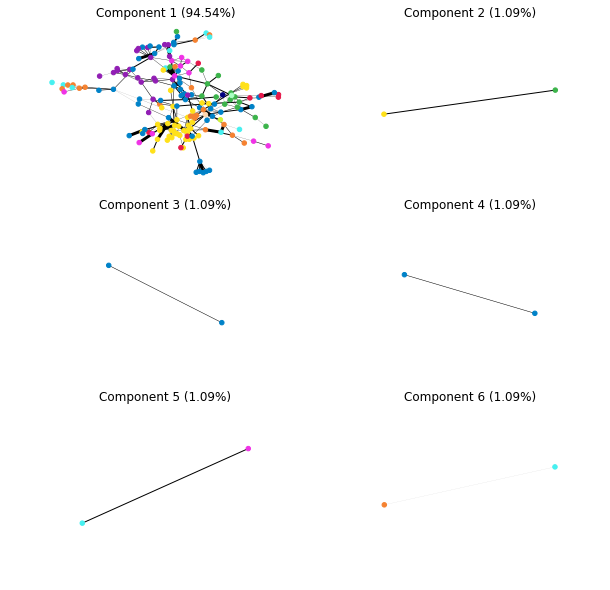

In [160]:
# display the connected components:
fig = plt.figure(figsize=(10, 10))
num_col = len(gccs) / 2
for i, g in enumerate(gccs, 1):
    percent = percentage[i - 1]
    ax = fig.add_subplot(num_col, 2, i)
    ax.axis('off')
    ax.set_title('Component {} ({:.2%})'.format(i, percent))
    nx.draw_networkx_nodes(
        g,
        node_color=color_by_inst(g),
        ax=ax,
        with_labels=False,
        node_size=20,
        pos=pos_6yr)
    g_edgewidth = [d['weight'] for (u, v, d) in g.edges(data=True)]
    nx.draw_networkx_edges(g, pos_6yr, width=np.multiply(g_edgewidth, 3))

plt.savefig("IMG/infnetweighted_CC.pdf", format='pdf', bbox_inches="tight")

In [156]:
main_gcc = gccs[0]

In [157]:
print('number of nodes in largest connected component:', len(main_gcc))
print(nx.info(main_gcc))

number of nodes in largest connected component: 173
Name: 
Type: Graph
Number of nodes: 173
Number of edges: 355
Average degree:   4.1040


## Giant Connected Component

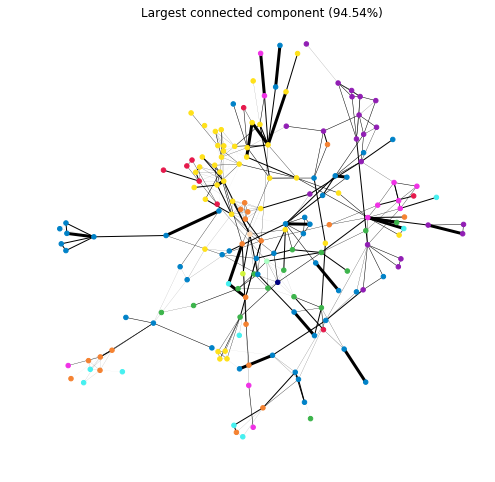

In [158]:
# Draw the graph:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
# ax = add_inst_labels(ax)
ax.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax,
    node_size=20,
    node_color=color_by_inst(main_gcc))
main_gcc_edgewidth = [d['weight'] for (u, v, d) in main_gcc.edges(data=True)]
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))
ax.set_title('Largest connected component ({:.2%})'.format(percentage[0]))

if SAVE_GRAPHS:
    plt.savefig(
    "IMG/infnet6yrw_LargestCC.pdf", format='pdf', bbox_inches="tight")

(array([35., 34.,  6., 34., 17.,  0., 15.,  0.,  0., 54.,  0.,  0.,  0.,
         0.,  0.,  0., 79.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0., 62.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.]),
 array([0.00362319, 0.01358696, 0.02355072, 0.03351449, 0.04347826,
        0.05344203, 0.0634058 , 0.07336957, 0.08333333, 0.0932971 ,
        0.10326087, 0.11322464, 0.12318841, 0.13315217, 0.14311594,
        0.15307971, 0.16304348, 0.17300725, 0.18297101, 0.19293478,
        0.20289855, 0.21286232, 0.22282609, 0.23278986, 0.24275362,
        0.25271739, 0.26268116, 0.27264493, 0.2826087 , 0.29257246,
        0.30253623, 0.3125

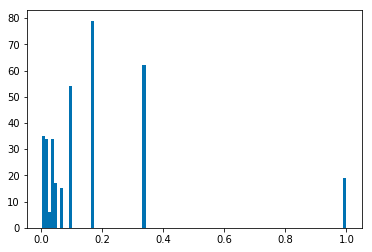

In [161]:
plt.hist(
    main_gcc_edgewidth, bins=100)

In [162]:
print('Average clustering coeff: ',
      nx.average_clustering(main_gcc, weight='weight'))

Average clustering coeff:  0.05962957857296951


In [163]:
print('Average shortest path length: ',
      nx.average_shortest_path_length(main_gcc, weight='weight'))

Average shortest path length:  0.6656710947376739


### Community Detection

In [ ]:
# Community detection using modularity
parts = community.best_partition(main_gcc)
values = [parts.get(node) for node in main_gcc.nodes()]
# assign each node to the community they belong to

In [ ]:
print('Number of communities detected: ', len(set(values)))

In [ ]:
# Plot the graphs side by side:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(
    'Comparison between actual institutes and communities detected\n(Colors of nodes for graph on right is independent of those on left)'
)
ax1 = fig.add_subplot(121)
ax1.set_title('Actual communities in informatics collaboration network')
ax1.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    with_labels=False,
    ax=ax1,
    node_size=20,
    node_color=color_by_inst(main_gcc))
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))

ax2 = fig.add_subplot(122)
ax2.set_title('Communities detected using modularity')
ax2.axis('off')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    cmap=plt.get_cmap("rainbow"),
    ax=ax2,
    node_color=values,
    node_size=20,
    with_labels=False)
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))
plt.savefig(
    "IMG/infnetweight_LargestCC_commCompare.pdf",
    format='pdf',
    bbox_inches="tight")

### Influential Individuals
We use the top scores for the eigenvector centrality to determine who are the most influential individuals

In [ ]:
evect_centrality = nx.eigenvector_centrality_numpy(main_gcc, weight='weight')

In [ ]:
max_nodes = sorted(evect_centrality.items(), key=lambda v: -v[1])[:top]
max_nodes

In [ ]:
bt_values = [10] * len(main_gcc.nodes())
bt_colors = ['xkcd:black'] * len(main_gcc.nodes())
for max_key, max_val in max_nodes:
    bt_values[_nodes.index(max_key)] = (max_val * 100)**2
    bt_colors[_nodes.index(max_key)] = inst_by_color[int(
        pd_poinf.institute_class.loc[[str(max_key)]])]

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
plt.axis("off")
plt.suptitle('The top 11 influential individuals in the GCC')
nx.draw_networkx_nodes(
    main_gcc,
    pos=pos_gcc,
    ax=ax,
    node_color=bt_colors,
    node_size=bt_values,
    with_labels=False)
nx.draw_networkx_edges(
    main_gcc, pos_gcc, width=np.multiply(main_gcc_edgewidth, 3))
plt.savefig(
    "IMG/infnetweight_influencer.pdf", format='pdf', bbox_inches="tight")

In [ ]:
top_ids = [a[0] for a in max_nodes]
pd_poinf.loc[top_ids]